In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from hmmlearn import hmm

import warnings
warnings.filterwarnings("ignore")

In [4]:
#'D:\\EOD\\EOD_20210908.csv'
input_df = pd.read_csv('C:\\Users\\ryans\\Desktop\\AMS\\EOD_20210908.csv',
                       header = None,
                       names = ['Ticker', # Label columns.
                                'Date',
                                'Open',
                                'High',
                                'Low',
                                'Close',
                                'Volume',
                                'Dividend',
                                'Stock_split',
                                'Adj_open',
                                'Adj_high',
                                'Adj_low',
                                'Adj_close',
                                'Adj_volume'])

In [5]:
data = input_df.loc[input_df['Ticker'] == 'SPY'] # Select which index to use for analysis
data.reset_index(inplace=True, drop=True)

In [6]:
data

,Ticker,Date,Open,High,Low,Close,Volume,Dividend,Stock_split,Adj_open,Adj_high,Adj_low,Adj_close,Adj_volume
0,SPY,1993-01-29,43.9687,43.9687,43.7500,43.9375,1003200.0,0.0,1.0,25.804239,25.804239,25.675889,25.785928,1003200.0
1,SPY,1993-02-01,43.9687,44.2500,43.9687,44.2500,480500.0,0.0,1.0,25.804239,25.969328,25.804239,25.969328,480500.0
2,SPY,1993-02-02,44.2187,44.3750,44.1250,44.3437,201300.0,0.0,1.0,25.950958,26.042687,25.895968,26.024318,201300.0
3,SPY,1993-02-03,44.4062,44.8437,44.3750,44.8125,529400.0,0.0,1.0,26.060998,26.317757,26.042687,26.299446,529400.0
4,SPY,1993-02-04,44.9687,45.0937,44.4687,45.0000,531500.0,0.0,1.0,26.391117,26.464476,26.097678,26.409486,531500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7199,SPY,2021-08-31,452.1300,452.4900,450.9200,451.5600,58631140.0,0.0,1.0,452.130000,452.490000,450.920000,451.560000,58631140.0
7200,SPY,2021-09-01,452.5600,453.1100,451.5450,451.8000,48667698.0,0.0,1.0,452.560000,453.110000,451.545000,451.800000,48667698.0
7201,SPY,2021-09-02,453.3200,454.0500,451.9100,453.1900,42479834.0,0.0,1.0,453.320000,454.050000,451.910000,453.190000,42479834.0
7202,SPY,2021-09-03,451.9800,453.6300,451.5500,453.0800,47155405.0,0.0,1.0,451.980000,453.630000,451.550000,453.080000,47155405.0


In [7]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [8]:
# Idealized (theoretical) results:
# Fit model to a training set (80% of the observations)
# Predict hidden state in sample and out of sample
# Assume fully invested if state 1, fully divested if state 0

data_ideal = data.copy()

In [9]:
sample_len = 10

Volatility = []
MA = []
Return = []
ma_sum = 0

# Warming up data for moving average and volatility calculations
for i in range (0, sample_len):
    Volatility.append(0);
    MA.append(0);
    Return.append(0);
    ma_sum += data_ideal['Adj_close'][i];

# Filling in data for return, moving average, and volatility
for i in data_ideal.index: 
    if i >= sample_len:
        tail_close = data_ideal['Adj_close'][i-sample_len];
        prev_close = data_ideal['Adj_close'][i-1];
        head_close = data_ideal['Adj_close'][i];
        ma_sum = (ma_sum - tail_close + head_close);
        ma_curr = ma_sum/sample_len;
        MA.append(ma_curr);
        Return.append(((head_close-prev_close)/prev_close)*100);
        #Computing Volatility
        vol_sum = 0;
        for j in range (0,sample_len):
            curr_vol = abs(ma_curr - data_ideal['Adj_close'][i-j]);
            vol_sum += (curr_vol ** 2);
        Volatility.append(vol_sum/sample_len);

In [10]:
# Adding columns to dataframe
data_ideal['Volatility'] = Volatility;
data_ideal['MA'] = MA;
data_ideal['Return'] = Return;

In [11]:
total_length = len(data_ideal)
train_length = round(len(data_ideal)*0.8)
test_length = total_length - train_length

# Create training and test sets
train = data_ideal.loc[:train_length-1]
test = data_ideal.loc[train_length:]
test.reset_index(inplace=True, drop=True)

In [12]:
# Number of rows & columns in each train and test set
train.shape,test.shape

((5763, 17), (1441, 17))

In [13]:
# Creating the HMM
states = 2
max_iterations = 100 # For EM algorithm

model_ideal = hmm.GaussianHMM(n_components = states, covariance_type="full", n_iter = max_iterations);
vol_ideal = train.iloc[:,14];
ret_ideal = train.iloc[:,16];
obs = [];
for i in range(0, len(vol_ideal)):
    arr = [];
    arr.append(vol_ideal[i]);
    arr.append(ret_ideal[i]);
    obs.append(arr);

# Fitting the model and obtaining predictions
model_ideal.fit(obs)
predictions = model_ideal.predict(obs)

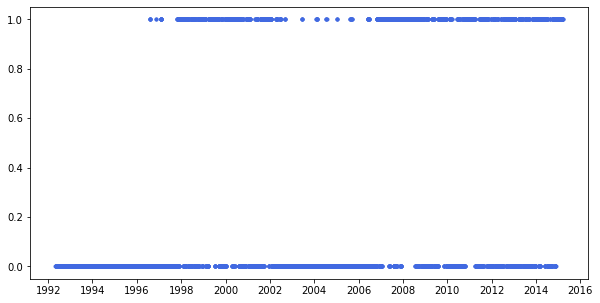

In [14]:
# Plot regime switches to graphically analyze

dates = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in train.Date]

fig, ax = plt.subplots(figsize=(10,5))

formatter = mdates.DateFormatter("%Y")

ax.xaxis.set_major_formatter(formatter)

fmt_half_year = mdates.MonthLocator(interval=24)
ax.xaxis.set_major_locator(fmt_half_year)

ax.plot(dates, predictions, '.', color = 'royalblue');

In [15]:
# Regime Classification

regime_vol_ideal = [];
regime_ret_ideal = [];
regime_count_ideal = [];
return_map_ideal = {};

for i in range(0, states):
    regime_vol_ideal.append(0);
    regime_ret_ideal.append(0);
    regime_count_ideal.append(0);

for i in range(0, len(predictions)):
    regime_count_ideal[predictions[i]] += 1;
    regime_vol_ideal[predictions[i]] += train.iloc[i, 14];
    regime_ret_ideal[predictions[i]] += train.iloc[i, 16];
    
    if not predictions[i] in return_map_ideal:
        return_map_ideal[predictions[i]] = [];
    return_map_ideal[predictions[i]].append(train.iloc[i,16]);
    
for i in range(0, states):
    regime_vol_ideal[i] = regime_vol_ideal[i] / regime_count_ideal[i];
    regime_ret_ideal[i] = regime_ret_ideal[i] / regime_count_ideal[i];

In [16]:
for i in range(0, states):
    print("Regime {0}".format(i))
    print("Avg Vol: {0}".format(regime_vol_ideal[i]));
    print("Avg Return: {0}".format(regime_ret_ideal[i]));
    print("Occurrence: {0}\n".format(regime_count_ideal[i]));

Regime 0
Avg Vol: 0.47140601044871105
Avg Return: 0.05488880218400304
Occurrence: 3840

Regime 1
Avg Vol: 3.6140368923582042
Avg Return: 0.0125753845654323
Occurrence: 1923



In [17]:
train_returns = train.Return/100

In [18]:
# Ensure that that the state with the larger mean is state '1'

if model_ideal.means_[1,0] > model_ideal.means_[1,1]:
    zeros = np.where(predictions == 0)
    ones = np.where(predictions == 1)

    predictions[zeros] = 1
    predictions[ones] = 0

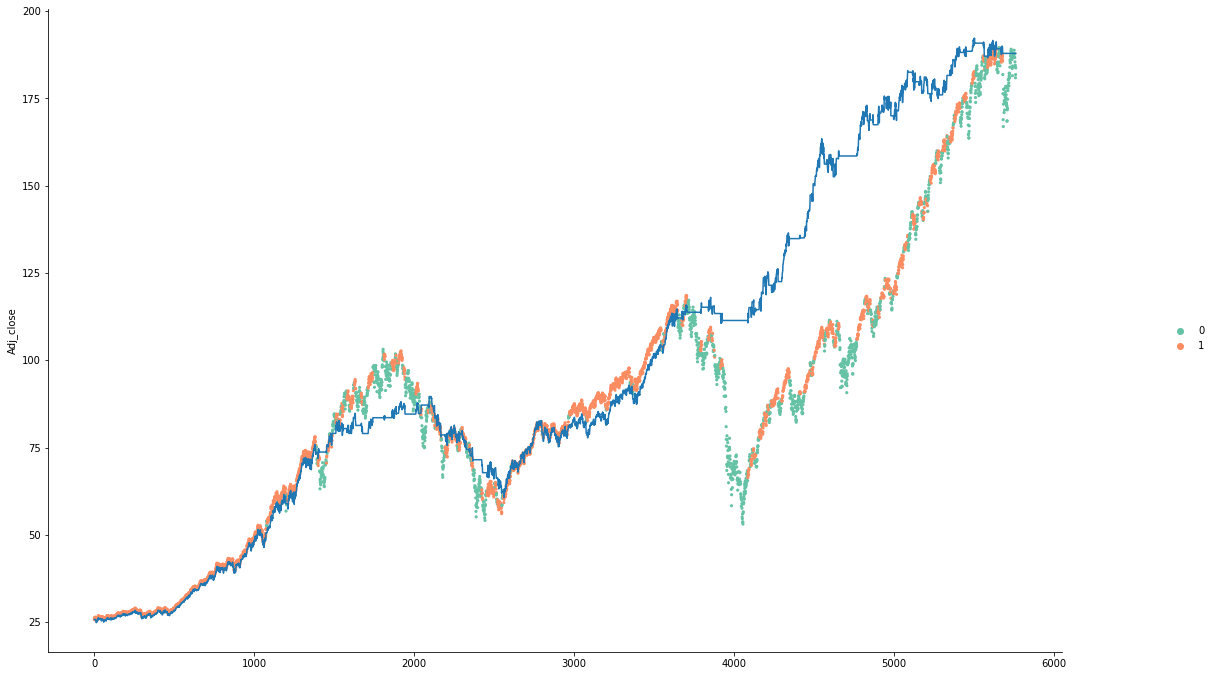

In [19]:
# Plot in-sample portfolio vs. actual returns

plot = sns.relplot(x=range(0,train_length), y="Adj_close", data=train, hue=predictions, 
            linewidth = 0, palette="Set2", s = 10);
plt.plot(range(0,train_length), np.cumprod(predictions * train_returns + 1) * train.Adj_close[0]);
plot.fig.set_size_inches(18,10)

In [20]:
# Idealized (theoretical) out-of-sample results

vol_ideal = test.iloc[:,14];
ret_ideal = test.iloc[:,16];
obs = [];
for i in range(0, len(vol_ideal)):
    arr = [];
    arr.append(vol_ideal[i]);
    arr.append(ret_ideal[i]);
    obs.append(arr);

predictions = model_ideal.predict(obs)

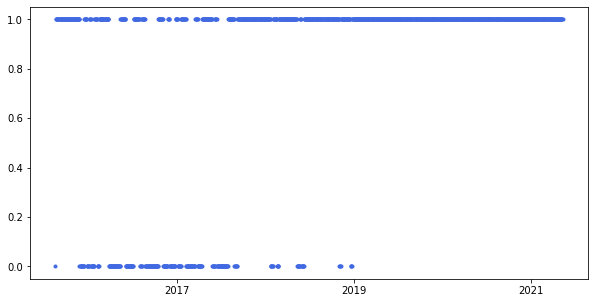

In [21]:
# Plot regime switches to graphically analyze

dates = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in test.Date]

fig, ax = plt.subplots(figsize=(10,5))

formatter = mdates.DateFormatter("%Y")

ax.xaxis.set_major_formatter(formatter)

fmt_half_year = mdates.MonthLocator(interval=24)
ax.xaxis.set_major_locator(fmt_half_year)

ax.plot(dates, predictions, '.', color = 'royalblue');

In [22]:
# Regime Classification

regime_vol_ideal = [];
regime_ret_ideal = [];
regime_count_ideal = [];
return_map_ideal = {};

for i in range(0, states):
    regime_vol_ideal.append(0);
    regime_ret_ideal.append(0);
    regime_count_ideal.append(0);

for i in range(0, len(predictions)):
    regime_count_ideal[predictions[i]] += 1;
    regime_vol_ideal[predictions[i]] += test.iloc[i, 14];
    regime_ret_ideal[predictions[i]] += test.iloc[i, 16];
    
    if not predictions[i] in return_map_ideal:
        return_map_ideal[predictions[i]] = [];
    return_map_ideal[predictions[i]].append(test.iloc[i,16]);
    
for i in range(0, states):
    regime_vol_ideal[i] = regime_vol_ideal[i] / regime_count_ideal[i];
    regime_ret_ideal[i] = regime_ret_ideal[i] / regime_count_ideal[i];

In [23]:
for i in range(0, states):
    print("Regime {0}".format(i))
    print("Avg Vol: {0}".format(regime_vol_ideal[i]));
    print("Avg Return: {0}".format(regime_ret_ideal[i]));
    print("Occurrence: {0}\n".format(regime_count_ideal[i]));

Regime 0
Avg Vol: 0.695898733751163
Avg Return: 0.015991418430917476
Occurrence: 298

Regime 1
Avg Vol: 17.223267615596992
Avg Return: 0.0828522864039944
Occurrence: 1143



In [24]:
test_returns = test.Return/100

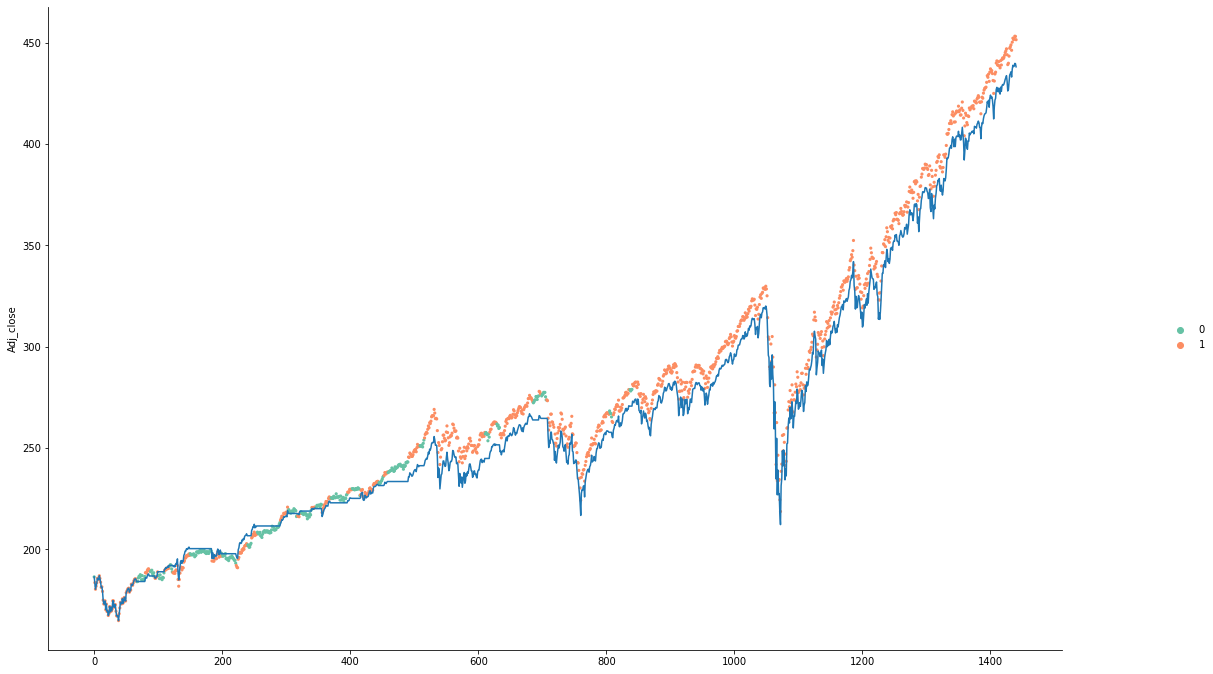

In [25]:
# Plot out-of-sample portfolio vs. actual returns

plot = sns.relplot(x=range(0,test_length), y="Adj_close", data=test, hue=predictions, 
            linewidth = 0, palette="Set2", s = 10);
plt.plot(range(0,test_length), np.cumprod(predictions * test_returns + 1) * test.Adj_close[0]);
plot.fig.set_size_inches(18,10)

In [123]:
# Proposed Idea: Create a HMM for the recent Neff days, and for all days after the Neff'th day
# Predict which state we are currently in based on the Neff recent days
# Be fully invested if in a positive market, full divested in a negative market

data = input_df.loc[input_df['Ticker'] == 'SPY'] # Select which index to use for analysis
data.reset_index(inplace=True, drop=True)

Neff = 750 # Lookback length

Return = 100*(data['Adj_close'] - data['Adj_close'].shift(1)) / data['Adj_close'].shift(1) # Calculate daily percentage returns

data['Return'] = Return

In [50]:
# Volatility = standard deviation for trailing Neff days
#Volatility = np.concatenate((np.zeros(Neff),
#                             [np.sqrt(sum((data['Return'][i:Neff+i] - np.mean(data['Return'][i:Neff+i]))**2) / Neff) for i in range(len(data)-Neff)]))

#data['Volatility'] = Volatility

In [124]:
#lookback = neff
def get_hvol_yz(df, lookback=10):
    o = df.Adj_open
    h = df.Adj_high
    l = df.Adj_low
    c = df.Adj_close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    #close_vol = pd.rolling_sum(cc_sq, window=lookback) * (1.0 / (lookback - 1.0))
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))

    #open_vol = pd.rolling_sum(oc_sq, window=lookback) * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum()  * (1.0 / (lookback - 1.0))
    
    #window_rs = pd.rolling_sum(rs, window=lookback) * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(260)
    result[:lookback-1] = 0.0
    
    return  result * 100

#If I don't multiply * 100 ,then it brings error even changed in Returns too 
#lookback option in this function should be less then our period(260)

In [125]:
new_vol=get_hvol_yz(data,lookback = 750)
data['Volatility'] = new_vol

In [126]:
data['Volatility']

0       0.000000 
1       0.000000 
2       0.000000 
3       0.000000 
4       0.000000 
5       0.000000 
6       0.000000 
7       0.000000 
8       0.000000 
9       0.000000 
10      0.000000 
11      0.000000 
12      0.000000 
13      0.000000 
14      0.000000 
15      0.000000 
16      0.000000 
17      0.000000 
18      0.000000 
19      0.000000 
20      0.000000 
21      0.000000 
22      0.000000 
23      0.000000 
24      0.000000 
25      0.000000 
26      0.000000 
27      0.000000 
28      0.000000 
29      0.000000 
30      0.000000 
31      0.000000 
32      0.000000 
33      0.000000 
34      0.000000 
35      0.000000 
36      0.000000 
37      0.000000 
38      0.000000 
39      0.000000 
40      0.000000 
41      0.000000 
42      0.000000 
43      0.000000 
44      0.000000 
45      0.000000 
46      0.000000 
47      0.000000 
48      0.000000 
49      0.000000 
50      0.000000 
51      0.000000 
52      0.000000 
53      0.000000 
54      0.000000 
55      0.

In [127]:
# Initialize a HMM
states = 2
max_iterations = 100 # For EM algorithm

# Initialize an array to track current regime
current_state = np.array([])

# Exclude first (to calculate trailing volatility) and second (to have a full set of observations to fit a HMM) Neff observations
for i in range(1, len(data) - 2*Neff):

    # Initialize a Gaussian HMM
    model = hmm.GaussianHMM(n_components = states, covariance_type="full", n_iter = max_iterations);

    # Pull Neff observations of Volatility and Returns    
    observations = np.stack((data['Volatility'][Neff+i:Neff*2+i], data['Return'][Neff+i:Neff*2+i]), axis=1)

    # Fit the model to the observations
    model.fit(observations)

    # Print to ensure loop is running
    print(f'i = {i}')

    # Model randomly allocates a '0' or a '1' to a state, so check which state has the higher mean return
    if model.means_[0,1] > model.means_[1,1]:
        positive_state = 0
    else:
        positive_state = 1

    # Predict the state for each observation
    predictions = model.predict(observations)

    # If the state with the higer mean return is state 1, do nothing, if not...
    if positive_state == 1:
        pass
    # Switch the predicted regimes to ensure state 1 is always the regime with a greater mean return
    else:
        zeros = np.where(predictions == 0)
        ones = np.where(predictions == 1)
        predictions[zeros] = 1
        predictions[ones] = 0
        
    # Append the current state to the regime tracker
    current_state = np.append(current_state,predictions[-1])
        
# Switch values from type float to type int for later calculations
current_state = current_state.astype(np.int64)

i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 138
i = 

i = 1037
i = 1038
i = 1039
i = 1040
i = 1041
i = 1042
i = 1043
i = 1044
i = 1045
i = 1046
i = 1047
i = 1048
i = 1049
i = 1050
i = 1051
i = 1052
i = 1053
i = 1054
i = 1055
i = 1056
i = 1057
i = 1058
i = 1059
i = 1060
i = 1061
i = 1062
i = 1063
i = 1064
i = 1065
i = 1066
i = 1067
i = 1068
i = 1069
i = 1070
i = 1071
i = 1072
i = 1073
i = 1074
i = 1075
i = 1076
i = 1077
i = 1078
i = 1079
i = 1080
i = 1081
i = 1082
i = 1083
i = 1084
i = 1085
i = 1086
i = 1087
i = 1088
i = 1089
i = 1090
i = 1091
i = 1092
i = 1093
i = 1094
i = 1095
i = 1096
i = 1097
i = 1098
i = 1099
i = 1100
i = 1101
i = 1102
i = 1103
i = 1104
i = 1105
i = 1106
i = 1107
i = 1108
i = 1109
i = 1110
i = 1111
i = 1112
i = 1113
i = 1114
i = 1115
i = 1116
i = 1117
i = 1118
i = 1119
i = 1120
i = 1121
i = 1122
i = 1123
i = 1124
i = 1125
i = 1126
i = 1127
i = 1128
i = 1129
i = 1130
i = 1131
i = 1132
i = 1133
i = 1134
i = 1135
i = 1136
i = 1137
i = 1138
i = 1139
i = 1140
i = 1141
i = 1142
i = 1143
i = 1144
i = 1145
i = 1146
i = 1147
i

i = 1951
i = 1952
i = 1953
i = 1954
i = 1955
i = 1956
i = 1957
i = 1958
i = 1959
i = 1960
i = 1961
i = 1962
i = 1963
i = 1964
i = 1965
i = 1966
i = 1967
i = 1968
i = 1969
i = 1970
i = 1971
i = 1972
i = 1973
i = 1974
i = 1975
i = 1976
i = 1977
i = 1978
i = 1979
i = 1980
i = 1981
i = 1982
i = 1983
i = 1984
i = 1985
i = 1986
i = 1987
i = 1988
i = 1989
i = 1990
i = 1991
i = 1992
i = 1993
i = 1994
i = 1995
i = 1996
i = 1997
i = 1998
i = 1999
i = 2000
i = 2001
i = 2002
i = 2003
i = 2004
i = 2005
i = 2006
i = 2007
i = 2008
i = 2009
i = 2010
i = 2011
i = 2012
i = 2013
i = 2014
i = 2015
i = 2016
i = 2017
i = 2018
i = 2019
i = 2020
i = 2021
i = 2022
i = 2023
i = 2024
i = 2025
i = 2026
i = 2027
i = 2028
i = 2029
i = 2030
i = 2031
i = 2032
i = 2033
i = 2034
i = 2035
i = 2036
i = 2037
i = 2038
i = 2039
i = 2040
i = 2041
i = 2042
i = 2043
i = 2044
i = 2045
i = 2046
i = 2047
i = 2048
i = 2049
i = 2050
i = 2051
i = 2052
i = 2053
i = 2054
i = 2055
i = 2056
i = 2057
i = 2058
i = 2059
i = 2060
i = 2061
i

i = 2864
i = 2865
i = 2866
i = 2867
i = 2868
i = 2869
i = 2870
i = 2871
i = 2872
i = 2873
i = 2874
i = 2875
i = 2876
i = 2877
i = 2878
i = 2879
i = 2880
i = 2881
i = 2882
i = 2883
i = 2884
i = 2885
i = 2886
i = 2887
i = 2888
i = 2889
i = 2890
i = 2891
i = 2892
i = 2893
i = 2894
i = 2895
i = 2896
i = 2897
i = 2898
i = 2899
i = 2900
i = 2901
i = 2902
i = 2903
i = 2904
i = 2905
i = 2906
i = 2907
i = 2908
i = 2909
i = 2910
i = 2911
i = 2912
i = 2913
i = 2914
i = 2915
i = 2916
i = 2917
i = 2918
i = 2919
i = 2920
i = 2921
i = 2922
i = 2923
i = 2924
i = 2925
i = 2926
i = 2927
i = 2928
i = 2929
i = 2930
i = 2931
i = 2932
i = 2933
i = 2934
i = 2935
i = 2936
i = 2937
i = 2938
i = 2939
i = 2940
i = 2941
i = 2942
i = 2943
i = 2944
i = 2945
i = 2946
i = 2947
i = 2948
i = 2949
i = 2950
i = 2951
i = 2952
i = 2953
i = 2954
i = 2955
i = 2956
i = 2957
i = 2958
i = 2959
i = 2960
i = 2961
i = 2962
i = 2963
i = 2964
i = 2965
i = 2966
i = 2967
i = 2968
i = 2969
i = 2970
i = 2971
i = 2972
i = 2973
i = 2974
i

i = 3778
i = 3779
i = 3780
i = 3781
i = 3782
i = 3783
i = 3784
i = 3785
i = 3786
i = 3787
i = 3788
i = 3789
i = 3790
i = 3791
i = 3792
i = 3793
i = 3794
i = 3795
i = 3796
i = 3797
i = 3798
i = 3799
i = 3800
i = 3801
i = 3802
i = 3803
i = 3804
i = 3805
i = 3806
i = 3807
i = 3808
i = 3809
i = 3810
i = 3811
i = 3812
i = 3813
i = 3814
i = 3815
i = 3816
i = 3817
i = 3818
i = 3819
i = 3820
i = 3821
i = 3822
i = 3823
i = 3824
i = 3825
i = 3826
i = 3827
i = 3828
i = 3829
i = 3830
i = 3831
i = 3832
i = 3833
i = 3834
i = 3835
i = 3836
i = 3837
i = 3838
i = 3839
i = 3840
i = 3841
i = 3842
i = 3843
i = 3844
i = 3845
i = 3846
i = 3847
i = 3848
i = 3849
i = 3850
i = 3851
i = 3852
i = 3853
i = 3854
i = 3855
i = 3856
i = 3857
i = 3858
i = 3859
i = 3860
i = 3861
i = 3862
i = 3863
i = 3864
i = 3865
i = 3866
i = 3867
i = 3868
i = 3869
i = 3870
i = 3871
i = 3872
i = 3873
i = 3874
i = 3875
i = 3876
i = 3877
i = 3878
i = 3879
i = 3880
i = 3881
i = 3882
i = 3883
i = 3884
i = 3885
i = 3886
i = 3887
i = 3888
i

i = 4689
i = 4690
i = 4691
i = 4692
i = 4693
i = 4694
i = 4695
i = 4696
i = 4697
i = 4698
i = 4699
i = 4700
i = 4701
i = 4702
i = 4703
i = 4704
i = 4705
i = 4706
i = 4707
i = 4708
i = 4709
i = 4710
i = 4711
i = 4712
i = 4713
i = 4714
i = 4715
i = 4716
i = 4717
i = 4718
i = 4719
i = 4720
i = 4721
i = 4722
i = 4723
i = 4724
i = 4725
i = 4726
i = 4727
i = 4728
i = 4729
i = 4730
i = 4731
i = 4732
i = 4733
i = 4734
i = 4735
i = 4736
i = 4737
i = 4738
i = 4739
i = 4740
i = 4741
i = 4742
i = 4743
i = 4744
i = 4745
i = 4746
i = 4747
i = 4748
i = 4749
i = 4750
i = 4751
i = 4752
i = 4753
i = 4754
i = 4755
i = 4756
i = 4757
i = 4758
i = 4759
i = 4760
i = 4761
i = 4762
i = 4763
i = 4764
i = 4765
i = 4766
i = 4767
i = 4768
i = 4769
i = 4770
i = 4771
i = 4772
i = 4773
i = 4774
i = 4775
i = 4776
i = 4777
i = 4778
i = 4779
i = 4780
i = 4781
i = 4782
i = 4783
i = 4784
i = 4785
i = 4786
i = 4787
i = 4788
i = 4789
i = 4790
i = 4791
i = 4792
i = 4793
i = 4794
i = 4795
i = 4796
i = 4797
i = 4798
i = 4799
i

i = 5604
i = 5605
i = 5606
i = 5607
i = 5608
i = 5609
i = 5610
i = 5611
i = 5612
i = 5613
i = 5614
i = 5615
i = 5616
i = 5617
i = 5618
i = 5619
i = 5620
i = 5621
i = 5622
i = 5623
i = 5624
i = 5625
i = 5626
i = 5627
i = 5628
i = 5629
i = 5630
i = 5631
i = 5632
i = 5633
i = 5634
i = 5635
i = 5636
i = 5637
i = 5638
i = 5639
i = 5640
i = 5641
i = 5642
i = 5643
i = 5644
i = 5645
i = 5646
i = 5647
i = 5648
i = 5649
i = 5650
i = 5651
i = 5652
i = 5653
i = 5654
i = 5655
i = 5656
i = 5657
i = 5658
i = 5659
i = 5660
i = 5661
i = 5662
i = 5663
i = 5664
i = 5665
i = 5666
i = 5667
i = 5668
i = 5669
i = 5670
i = 5671
i = 5672
i = 5673
i = 5674
i = 5675
i = 5676
i = 5677
i = 5678
i = 5679
i = 5680
i = 5681
i = 5682
i = 5683
i = 5684
i = 5685
i = 5686
i = 5687
i = 5688
i = 5689
i = 5690
i = 5691
i = 5692
i = 5693
i = 5694
i = 5695
i = 5696
i = 5697
i = 5698
i = 5699
i = 5700
i = 5701
i = 5702
i = 5703


In [128]:
total_regime_switches = sum(np.abs(current_state[1:] - current_state[:-1]))
total_regime_switches

75

In [129]:
years_of_data = len(current_state) / 252 # Approximately 252 trading days in a year
years_of_data

22.63095238095238

In [130]:
avg_regime_changes_per_year = total_regime_switches / years_of_data
avg_regime_changes_per_year

3.314045239347712

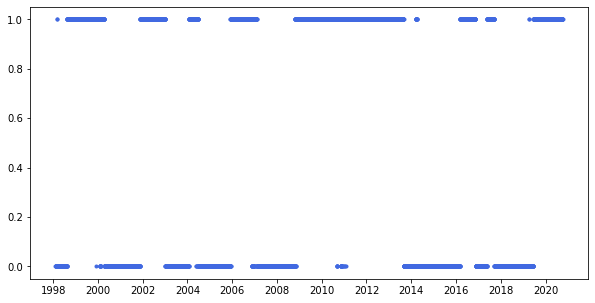

In [131]:
# Plot regime switches to graphically analyze

dates = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in data.Date[2*Neff + 1:]]

fig, ax = plt.subplots(figsize=(10,5))

formatter = mdates.DateFormatter("%Y")

ax.xaxis.set_major_formatter(formatter)

fmt_half_year = mdates.MonthLocator(interval=24)
ax.xaxis.set_major_locator(fmt_half_year)

ax.plot(dates, current_state, '.', color = 'royalblue');

In [132]:
state_0 = np.where(current_state == 0)[0] + 2*Neff + 1
state_1 = np.where(current_state == 1)[0] + 2*Neff + 1

In [133]:
# Calculate and view statistics of the two states

print(len(state_0))
print(data.loc[state_0].Return.mean())
print(data.loc[state_0].Return.std())
print('\n')
print(len(state_1))
print(data.loc[state_1].Return.mean())
print(data.loc[state_1].Return.std())

2834
0.034225150766797836
1.4206599167492098


2869
0.04000175362229262
1.0236802829385692


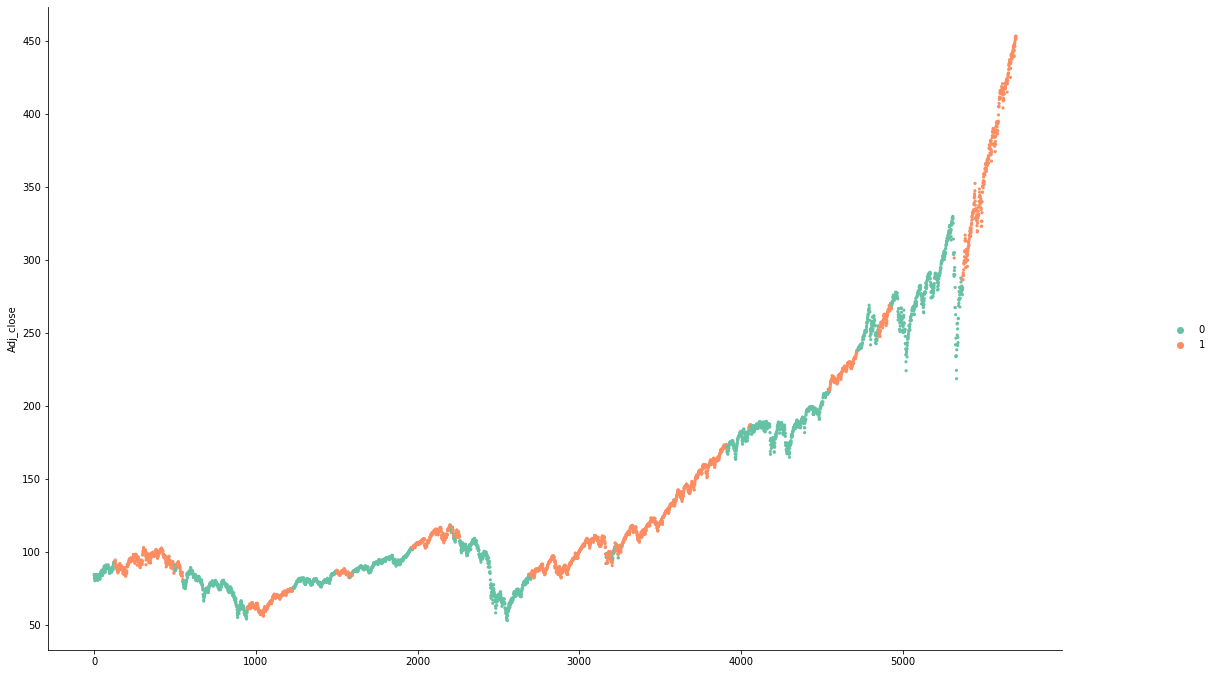

In [134]:
# Plot the returns of the data, segmented by hidden state

plot = sns.relplot(x = range(0,len(current_state)),
                   y = "Adj_close",
                   data = data[2*Neff+1:],
                   hue = current_state,
                   linewidth = 0,
                   palette = "Set2",
                   s = 10);

plot.fig.set_size_inches(18,10)

In [135]:
# Calculate the growth of a theoretical portfolio
# Assume fully invested if state 1, fully divested if state 0

current_portfolio = data.Adj_close[2*Neff+1] * np.cumprod(current_state * data.Return[2*Neff+1:] / 100 + 1)


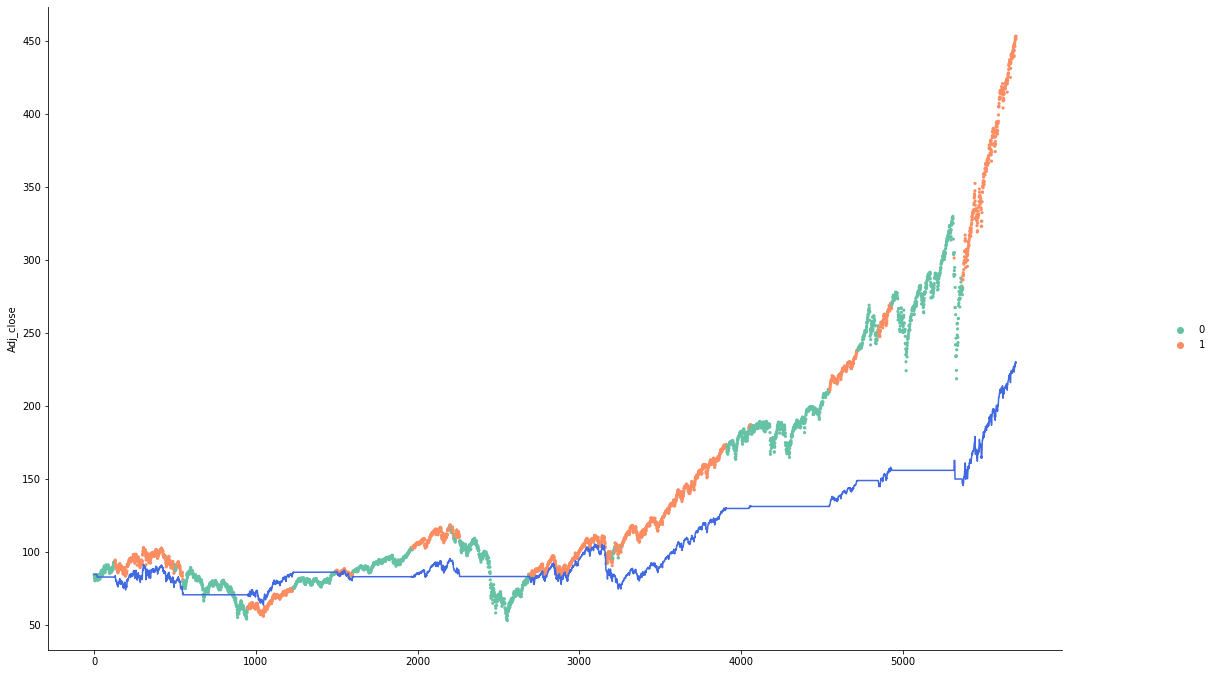

In [136]:
# Plot the return portfolio dynamics

plot = sns.relplot(x = range(0,len(current_state)),
                   y = "Adj_close",
                   data = data[2*Neff+1:],
                   hue = current_state,
                   linewidth = 0,
                   palette = "Set2",
                   s = 10);

plt.plot(range(0,len(current_state)), current_portfolio, color='royalblue')

plot.fig.set_size_inches(18,10)

In [120]:
current_portfolio_returns = current_portfolio.pct_change(1)
current_portfolio_sharpe = current_portfolio_returns.mean()/current_portfolio_returns.std()
current_portfolio_sharpe

0.02777471144166273

In [121]:
np.savetxt("test_portfolio_260.csv", current_portfolio_returns, delimiter=',')

In [122]:
# Import previous iterations using different Neff window lengths
test_portfolio_750 = np.loadtxt("test_portfolio_750.csv")
test_portfolio_500 = np.loadtxt("test_portfolio_500.csv")
test_portfolio_250 = np.loadtxt("test_portfolio_250.csv")

fig, ax = plt.subplots(figsize=(18,10))

ax.plot(range(0,len(current_state)+500), data.Adj_close[2*250+1:], color='slategray', label = '');
ax.plot(range(1000,len(current_state)+500), test_portfolio_750, color='royalblue',label = '750');
ax.plot(range(500,len(current_state)+500), test_portfolio_500, color='darkgreen',label = '500');
ax.plot(range(0,len(current_state)+500), test_portfolio_250, color='darkviolet',label = '250');

ax.legend(loc="upper left", title="Legend Title", frameon=False)



OSError: test_portfolio_750.csv not found.

In [ ]:
# Calculate Sharpe Ratios

test_portfolio_750_returns = (test_portfolio_750[1:] - test_portfolio_750[:-1]) / test_portfolio_750[:-1]
test_portfolio_750_sharpe = test_portfolio_750_returns.mean()/test_portfolio_750_returns.std()
print(test_portfolio_750_sharpe)

In [ ]:
# Calculate Sharpe Ratios

test_portfolio_500_returns = (test_portfolio_500[1:] - test_portfolio_500[:-1]) / test_portfolio_500[:-1]
test_portfolio_500_sharpe = test_portfolio_500_returns.mean()/test_portfolio_500_returns.std()
print(test_portfolio_500_sharpe)

In [ ]:
# Calculate Sharpe Ratios

test_portfolio_250_returns = (test_portfolio_250[1:] - test_portfolio_250[:-1]) / test_portfolio_250[:-1]
test_portfolio_250_sharpe = test_portfolio_250_returns.mean()/test_portfolio_250_returns.std()
print(test_portfolio_250_sharpe)